# Variational Auto-encoder

This notebook presents a variational auto-encoder ([paper](https://arxiv.org/abs/1312.6114)) for trajectory generation.

In [1]:
import altair as alt

from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP
import pandas as pd
from tqdm import tqdm

import torch

from deep_traffic_generation.core.utils import traffic_from_data

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

In [2]:
N_SAMPLES = 100

In [3]:
dataset = TrafficDataset.from_file(
    "../deep_traffic_generation/data/traffic_15.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)
dataset

Dataset TrafficDataset
    Number of datapoints: 3968
    MinMaxScaler(feature_range=(-1, 1))

In [4]:
model = TCVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tcvae/version_0/checkpoints/epoch=1988-step=5966.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tcvae/version_0/hparams.yaml",
    dataset_params=dataset.parameters,
)
model.eval()

TCVAE(
  (encoder): Sequential(
    (0): TCN(
      (network): Sequential(
        (0): ResidualBlock(
          (tmp_block1): TemporalBlock(
            (conv): Conv1d(4, 16, kernel_size=(16,), stride=(1,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (tmp_block2): TemporalBlock(
            (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
        )
        (1): ResidualBlock(
          (tmp_block1): TemporalBlock(
            (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (tmp_block2): TemporalBlock(
            (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (2): ResidualBlock(
          (tmp_block1): TemporalBlock(


In [5]:
h = model.encoder(dataset.data)
q = model.lsr(h)
z = q.rsample()
x = z.detach().cpu().numpy()
# z_scale = np.exp(z_scale.detach().cpu().numpy() / 2)
x.shape

(3968, 32)

### Reconstruction

In [6]:
original, info = dataset[0]
_, _, reconstruction = model(original.unsqueeze(0))

data = torch.cat((original.unsqueeze(0).transpose(1, 2), reconstruction.detach().transpose(1, 2)))
data.size()

torch.Size([2, 200, 4])

In [7]:
data = data.view((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)
data.shape

(2, 800)

In [8]:
info = info.repeat(2, 1)
info.size()

torch.Size([2, 2])

In [9]:
# add latitude longitude info
data = np.concatenate((info.numpy(), data), axis=1)
print(data.shape)
builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)
traffic

(2, 802)


,count
flight_id,
TRAJ_0,200
TRAJ_1,200


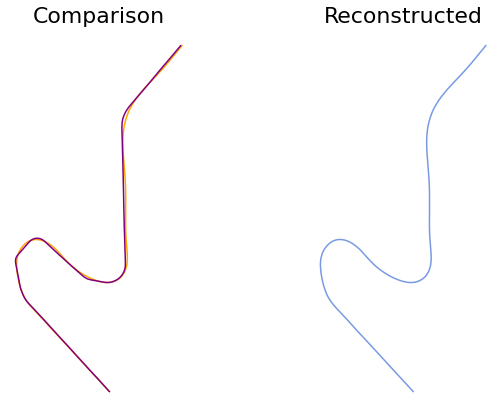

In [10]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    traffic[1].plot(ax[0], c="orange", label="reconstructed")
    traffic[0].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Reconstructed")
    traffic[1].plot(ax[1])

    plt.show()

In [11]:
traffic[0].chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [12]:
traffic[1].chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [13]:
traffic[0].chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [14]:
traffic[1].chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

### Generation

In [15]:
p = model.lsr.get_prior(N_SAMPLES)
x_sim = p.sample()
x_sim.size()

torch.Size([100, 32])

In [16]:
encodings = np.concatenate((x, x_sim), axis=0)
encodings.shape

(4068, 32)

In [17]:
z_embedded = TSNE(n_components=2).fit_transform(encodings)
z_embedded.shape

(4068, 2)

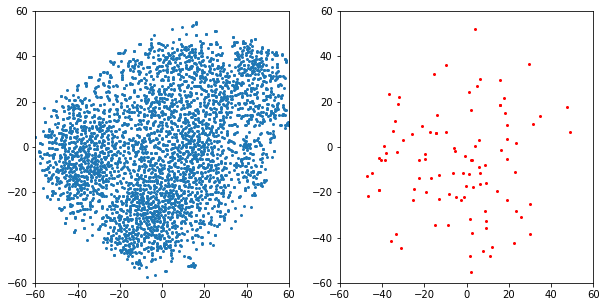

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(z_embedded[:len(dataset), 0], z_embedded[:len(dataset), 1], s=4)
ax[1].scatter(z_embedded[len(dataset):, 0], z_embedded[len(dataset):, 1], s=4, c='red')

for ax_ in ax:
    ax_.set_xlim(-60, 60)
    ax_.set_ylim(-60, 60)

plt.show()

Find closest original trajectories

In [19]:
Xg = x_sim.T
Xr = x.T
print(f"X generated: {Xg.shape}")
print(f"X real: {Xr.shape}")

X generated: torch.Size([32, 100])
X real: (32, 3968)


In [20]:
diff = (Xg[np.newaxis,...] - Xr[np.newaxis,...].T)
D = np.sqrt((diff**2).sum(1)).T
originals_idx = np.argmin(D, axis=1)

In [21]:
originals, info = dataset[originals_idx]
originals = torch.transpose(originals, 1, 2)
originals.size()

torch.Size([100, 200, 4])

In [22]:
data = originals.detach()
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [23]:
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic_original = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

if "track" not in traffic_original.data.columns:
    traffic_original = traffic_original.cumulative_distance().eval(desc="")

traffic_original

,count
flight_id,
TRAJ_0,200
TRAJ_66,200
TRAJ_75,200
TRAJ_74,200
TRAJ_73,200
TRAJ_72,200
TRAJ_71,200
TRAJ_70,200
TRAJ_7,200


Decode generated samples

In [24]:
outputs = model.decoder(torch.Tensor(x_sim))
outputs = torch.transpose(outputs, 1, 2)
outputs.size()

torch.Size([100, 200, 4])

In [25]:
data = outputs.detach()
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [26]:
# add latitude longitude info
# data = data.reshape((10, -1))
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
t_gen = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

if "track" not in t_gen.data.columns:
    t_gen = (
        t_gen
        .cumulative_distance()
        .rename(columns=dict(compute_gs="groundspeed", compute_track="track"))
        .eval(desc="")
    )

t_gen

,count
flight_id,
TRAJ_0,200
TRAJ_66,200
TRAJ_75,200
TRAJ_74,200
TRAJ_73,200
TRAJ_72,200
TRAJ_71,200
TRAJ_70,200
TRAJ_7,200


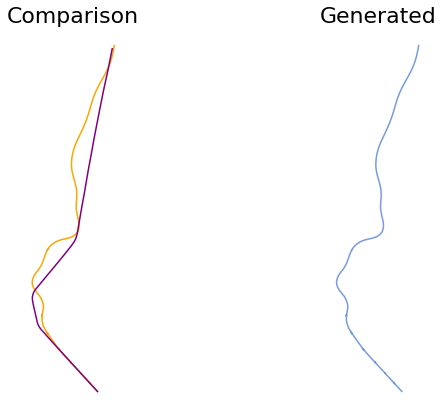

In [27]:
flight_id = 20
generated = t_gen[f"TRAJ_{flight_id}"]
original = traffic_original[f"TRAJ_{flight_id}"]
    
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    generated.plot(ax[0], c="orange", label="generated")
    original.plot(ax[0], c="purple", label="closest original")
    ax[1].set_title("Generated")
    generated.plot(ax[1])

    plt.show()

In [28]:
generated.chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [29]:
generated.chart().encode(alt.Y("groundspeed"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [30]:
generated.chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

Save generated trajectories into csv file

In [31]:
t_gen.to_csv("./outputs/vae_gen.csv")

### Douglas-Peucker

In [32]:
simplified_t_gen = (
    t_gen
    .simplify(tolerance=1e3)
    .eval(desc="")
)
simplified_t_gen.data

  0%|          | 0/100 [00:00<?, ?it/s]

,track,groundspeed,altitude,timedelta,latitude,longitude,flight_id,callsign,icao24,timestamp
0,201.947691,209.114804,14964.690428,0.027012,48.097859,8.685354,TRAJ_0,TRAJ_0,TRAJ_0,2021-09-30 14:05:40.027011633+00:00
14,173.796781,222.104009,14234.324522,60.332048,48.040300,8.674541,TRAJ_0,TRAJ_0,TRAJ_0,2021-09-30 14:06:40.332047723+00:00
58,166.731005,237.038075,10701.919135,249.816017,47.844748,8.749748,TRAJ_0,TRAJ_0,TRAJ_0,2021-09-30 14:09:49.816017389+00:00
68,203.879121,228.802694,9992.679484,293.281320,47.799391,8.742305,TRAJ_0,TRAJ_0,TRAJ_0,2021-09-30 14:10:33.281319618+00:00
76,230.208440,216.445813,9777.165316,327.448094,47.772033,8.711254,TRAJ_0,TRAJ_0,TRAJ_0,2021-09-30 14:11:07.448093891+00:00
...,...,...,...,...,...,...,...,...,...,...
19882,198.298516,279.592469,8702.598561,280.241826,47.803101,8.581544,TRAJ_99,TRAJ_99,TRAJ_99,2021-09-30 14:10:20.241826355+00:00
19898,219.310395,282.551870,6966.103085,336.166363,47.757499,8.500722,TRAJ_99,TRAJ_99,TRAJ_99,2021-09-30 14:11:16.166363418+00:00
19927,190.233036,265.744063,4694.819441,435.782288,47.650559,8.401802,TRAJ_99,TRAJ_99,TRAJ_99,2021-09-30 14:12:55.782287955+00:00
19942,153.659180,215.674606,4265.884081,488.176204,47.594853,8.402241,TRAJ_99,TRAJ_99,TRAJ_99,2021-09-30 14:13:48.176204205+00:00


In [33]:
simplified_t_gen.to_csv("./outputs/dp_vae_gen.csv")

### Navigational Points

In [34]:
navpoints_t_gen = pd.concat([
    flight
    .compute_navpoints()
    .assign(
        flight_id=flight.flight_id,
        callsign=flight.callsign,
        icao24=flight.icao24,
        registration=flight.registration,
        typecode=flight.typecode,
        latitude_0=flight.data.iloc[0].latitude,
        longitude_0=flight.data.iloc[0].longitude,
        altitude_0=flight.data.iloc[0].altitude,
        track_0=flight.data.iloc[0].track,
        groundspeed_0=flight.data.iloc[0].groundspeed,
    )
    .drop(columns=[
        "altitude",
        "description",
        "frequency",
        "magnetic_variation"
    ])
    for flight in tqdm(t_gen)
])
navpoints_t_gen.head()

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


,start,stop,duration,navaid,distance,shift_mean,shift_meanp,name,type,latitude,...,flight_id,callsign,icao24,registration,typecode,latitude_0,longitude_0,altitude_0,track_0,groundspeed_0
0,2021-09-30 14:06:44.510742962+00:00,2021-09-30 14:10:01.683991864+00:00,0 days 00:03:17.173248902,D179G,21.150377,0.184439,0.204439,D179G,FIX,47.482242,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.097859,8.685354,14964.690428,201.947691,209.114804
1,2021-09-30 14:11:20.562613308+00:00,2021-09-30 14:13:04.973394394+00:00,0 days 00:01:44.410781086,ZH005,1.296797,0.036910,0.056910,ZH005,FIX,47.701167,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.097859,8.685354,14964.690428,201.947691,209.114804
2,2021-09-30 14:14:20.268864125+00:00,2021-09-30 14:15:26.147106409+00:00,0 days 00:01:05.878242284,CF14,2.496374,0.033521,0.053521,CF14,FIX,47.637272,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.097859,8.685354,14964.690428,201.947691,209.114804
3,2021-09-30 14:17:19.825396776+00:00,2021-09-30 14:19:29.587282866+00:00,0 days 00:02:09.761886090,ML14,0.097361,0.016588,0.036588,ML14,FIX,47.496900,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.097859,8.685354,14964.690428,201.947691,209.114804
0,2021-09-30 14:05:49.795005441+00:00,2021-09-30 14:06:26.029556364+00:00,0 days 00:00:36.234550923,ZH005,18.692201,0.219067,0.239067,ZH005,FIX,47.701167,...,TRAJ_1,TRAJ_1,TRAJ_1,None,None,48.072829,8.429009,13642.691494,169.818195,329.128851


In [35]:
navpoints_t_gen.to_csv("./outputs/nav_vae_gen.csv")